## **1. Classical Least Square Inversion**

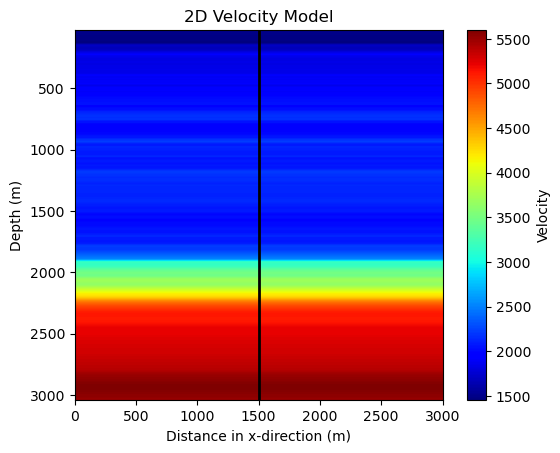

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import interp1d
from dwave.system import DWaveSampler, EmbeddingComposite
import matplotlib.pyplot as plt

# Define grid dimensions
dx = 5
dz = 5
lx = 3000
lz = 5804

# Calculate number of grid points
nx = int(lx / dx)
nz = int(lz / dz)

# Load velocity data from file
data = np.loadtxt('data.txt')  # Replace 'data.txt' with the actual path to your data file
z_data = data[:, 0]
velocity_data = data[:, 1]

# Create a grid for z values based on model dimensions
z_grid = np.linspace(min(z_data), max(z_data), nz)

# Interpolate velocity data to match the z grid of the model
velocity_z_interp = np.interp(z_grid, z_data, velocity_data)

# Create 2D velocity model by replicating the 1D velocity profile across the x direction
velocity_model = np.tile(velocity_z_interp, (nx, 1)).T

# Plot the model
plt.figure()
plt.imshow(velocity_model, extent=[0, lx, max(z_grid), min(z_grid)], aspect='auto', cmap='jet')
cbar = plt.colorbar(label='Velocity')

# Add a label for the color bar
cbar.ax.set_ylabel('Velocity')


plt.xlabel('Distance in x-direction (m)')
plt.ylabel('Depth (m)')
plt.title('2D Velocity Model')
plt.gca().set_aspect('equal', adjustable='box')
plt.axvline(x=lx/2, color='black', linewidth=2)  # Draws a black vertical line in the middle
plt.show()

### Interpolation

In [7]:
data

array([[  25.  , 1495.21],
       [  29.  , 1487.93],
       [  33.  , 1487.87],
       ...,
       [3031.99, 5512.56],
       [3035.99, 5505.39],
       [3039.99, 5503.51]])

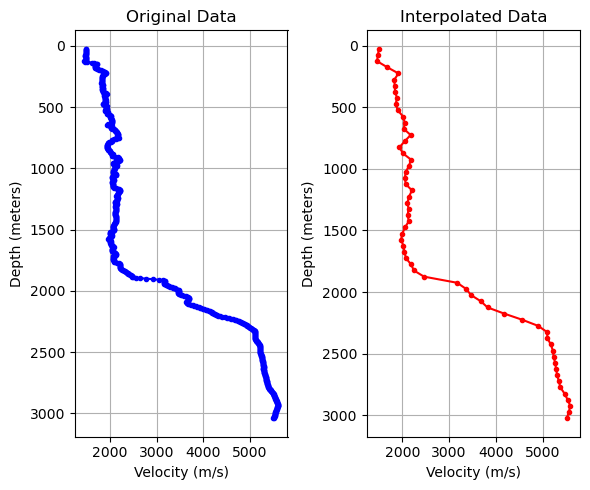

In [43]:
# Loading the newly uploaded 'data.txt' and continuing with the conversion of the MATLAB script to Python
data = np.loadtxt('data.txt')
n = len(data)



# Load data from the uploaded 'data.txt' file
data_path = 'data.txt'
data = np.loadtxt(data_path)

# Extract x (depth) and v (velocity)
x = data[:, 0]
v = data[:, 1]

# Calculate the step size based on the min, max of x and the size of x
step_size = (np.max(x) - np.min(x)) / (len(x)-1)

# Creating a new x array with regular spacing
x_regular = np.arange(np.min(x), np.max(x), 50)

# Interpolating to find the corresponding v values at the new x positions
interpolation_function = interp1d(x, v, kind='linear')
v_regular = interpolation_function(x_regular)


# Creating a figure with two subplots, inverting the y-axis
plt.figure(figsize=(6, 5))

# First subplot with original data
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(v, x, marker='.', linestyle='-', color='blue')
plt.title('Original Data')
plt.ylabel('Depth (meters)')
plt.xlabel('Velocity (m/s)')
plt.gca().invert_yaxis()  # Inverting the y-axis
plt.grid(True)

# Second subplot with interpolated data
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(v_regular, x_regular, marker='.', linestyle='-', color='red')
plt.title('Interpolated Data')
plt.ylabel('Depth (meters)')
plt.xlabel('Velocity (m/s)')
plt.gca().invert_yaxis()  # Inverting the y-axis
plt.grid(True)

# Show the figure
plt.tight_layout()  # Adjust layout to not overlap
plt.show()

# Save interpolated data
np.savetxt('data_interpolated.txt', np.column_stack((x_regular, v_regular)), fmt='%f')

In [17]:
len(x)

751

In [15]:
np.max(x_regular)

3039.990000000001

### Least square inversion

In [19]:
# Loading the newly uploaded 'data_interpolated.txt' and continuing with the conversion of the MATLAB script to Python
data = np.loadtxt('data_interpolated.txt')
n = len(data)

# Extracting x and v from the loaded data
x = data[:, 0]
v = data[:, 1]
depth = x

# Calculating h and delta
h = np.diff(x)
delta = h * 1.5
# delta = h * 5.6

# Calculating two-way travel time (t)
t = np.zeros(n-1)
for i in range(n-1):
    sumtemp = 0
    for j in range(i+1):
        theta = np.arctan(delta[j] / h[j])
        dij = h[j] / np.cos(theta)
        temp = dij / v[j]
        sumtemp += temp
    t[i] = sumtemp * 2

# Preparing matrix M for inversion
m = n - 1
M = np.zeros((m, m))
theta = np.arctan(delta / h)

for j in range(m):
    M[j:, j] = 2 * h[j] / np.cos(theta[j])

# Using least squares to solve for s
s, residuals, rank, s_val = np.linalg.lstsq(M, t, rcond=None)
v_inversion = np.power(s, -1)
s1 = s

Text(0, 0.5, '2-way travel time (s)')

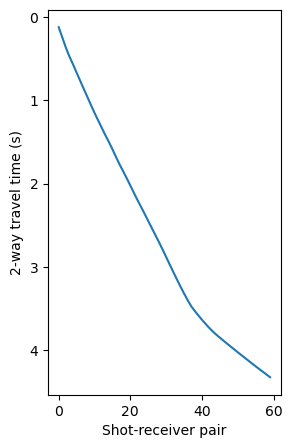

In [20]:
plt.figure(figsize=(3, 5))


plt.plot(t)
plt.gca().invert_yaxis()

plt.xlabel('Shot-receiver pair')
plt.ylabel('2-way travel time (s)')

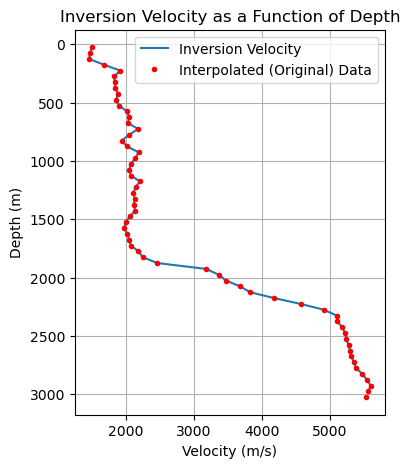

In [21]:
# Plotting the inversion velocity
plt.figure(figsize=(4, 5))
plt.plot(v_inversion, x[:-1], label='Inversion Velocity')
plt.plot(v, x, ".", label='Interpolated (Original) Data', color="red")
plt.gca().invert_yaxis()  # Reverse the Y-axis to have depth increase downwards
plt.xlabel('Velocity (m/s)')
plt.ylabel('Depth (m)')
plt.title('Inversion Velocity as a Function of Depth')
plt.grid(True)
plt.legend()
plt.show()

## **2. Quantum Annealing Machine - Binary Least Square Problem**

### **Entry problem**

In [22]:
import numpy as np
from dwave.system import DWaveSampler, EmbeddingComposite
"""
Dwave sampler is an object that represents the quantum annealer itself. It is responsible for directly interacting with the quantum hardware.
When you create an instance of DWaveSampler, you are preparing to submit your optimization problem to a D-Wave quantum annealer for solution.

EmbeddingComposite is a wrapper around samplers that automatically handles the problem of embedding. Embedding is the process of mapping your
problem from its logical representation to the physical representation.

"""

def dict_to_vector_auto(q_dict):
    """
    Convert a solution dictionary from a QUBO problem into a vector representation.
    
    Args:
        q_dict (dict): The solution dictionary where keys are variable indices and values are the binary values.
    
    Returns:
        np.ndarray: The vector representation of the solution.
    """
    # Determine the size of the vector (n) based on the highest index in q_dict
    n = max(q_dict.keys()) + 1
    
    # Initialize a vector of size n with zeros
    q_vector = np.zeros(n, dtype=int)
    
    # Populate the vector with the values from the solution dictionary
    for i, value in q_dict.items():
        q_vector[i] = value
    
    return q_vector
def qubo_to_matrix_auto(Q):
    """
    Convert a QUBO problem defined by a dictionary into a matrix representation,
    automatically determining the matrix size.
    
    Args:
        Q (dict): The QUBO problem coefficients, where keys are tuples representing interactions between variables,
                  and values are the weights of these interactions.
    
    Returns:
        np.ndarray: The matrix representation of the QUBO problem.
    """
    # Determine the size of the matrix (n) based on the highest index in Q
    n = max(max(pair) for pair in Q.keys()) + 1
    
    # Initialize an nxn matrix with zeros
    Q_matrix = np.zeros((n, n))
    
    # Populate the matrix with the values from the QUBO dictionary
    for (i, j), value in Q.items():
        Q_matrix[i, j] = value
        if i != j:  # Ensure the matrix is symmetric
            Q_matrix[j, i] = value
    
    return Q_matrix
def binary_least_squares_qubo(A, b):
    """
    Transforms the binary least squares problem into a QUBO problem.
    Args:
        A (np.ndarray): The matrix A in the binary least squares problem.
        b (np.ndarray): The vector b in the binary least squares problem.
    Returns:
        dict: The QUBO coefficients.
    """
    # Number of variables
    n = A.shape[1]

    # Compute A^T * A and A^T * b
    ATA = A.T @ A
    ATb = A.T @ b

    # Initialize the QUBO dictionary
    Q = {}

    # Fill the QUBO coefficients
    for i in range(n):
        for j in range(i, n):
            if i == j:  # Diagonal entries
                Q[(i, i)] = ATA[i, i] - 2 * ATb[i]
            else:  # Off-diagonal entries
                Q[(i, j)] = 2 * ATA[i, j]

    return Q
def calculate_objective_value(A, b, q):
    """
    Calculates the objective value ||Aq - b||^2 for a given binary vector q.

    Args:
        A (np.ndarray): The matrix A.
        b (np.ndarray): The vector b.
        q (np.ndarray): The binary vector q for which to calculate the objective value.

    Returns:
        float: The calculated objective value.
    """
    # Ensure q is a numpy array for matrix operations
    q = np.array(q)
    
    # Calculate the difference between Aq and b
    diff = np.dot(A, q) - b
    
    # Calculate the objective value as the square of the L2 norm of the difference
    objective_value = np.dot(diff, diff)
    
    return objective_value

# Define or generate your A (10x10) and b (10-dimensional)
np.random.seed(999)  # For reproducible random results
sizematrix = 18
A = np.random.randint(1, 10, size=(sizematrix, sizematrix-2))
b = np.random.randint(1, 10, size=(sizematrix,))


# Convert the binary least squares problem to QUBO
Q = binary_least_squares_qubo(A, b)

# Solve the QUBO using D-Wave's system
sampler = EmbeddingComposite(DWaveSampler())
sampleset = sampler.sample_qubo(Q, num_reads=100)
"""
The num_reads refers to the number of times the QA process is repeated.
The QAM is a probabilistic method, meaning that it may not find the absolute best solution on every run
due to its reliance on quantum fluctuations and thermal dynamics.
Therefore by increasing the num_read, we increase the chances of finding the global minimum of the problem's energy landscape.
High num_reads: increases the probability of finding the optimal solution but requres more times and resources.
Low num_reads: faster and uses fewer resources but might miss the optimal solution.
So far, what all we need is the QUBO Matrix.
"""
# Print the best sample
q = dict_to_vector_auto(sampleset.first.sample)

print("A:")
print(A)
print("\nb:", b)
print("\nBest binary vector q:", q)
print("Minimum objective value:", calculate_objective_value(A,b,q))

A:
[[1 6 2 9 2 4 1 6 9 9 1 6 3 6 8 5]
 [7 3 8 7 2 6 4 7 5 1 5 5 9 8 3 8]
 [5 5 6 2 7 9 2 2 2 7 4 4 9 1 2 5]
 [1 7 5 8 4 5 8 5 7 5 8 4 1 5 5 7]
 [9 7 1 5 7 8 1 2 3 6 8 3 2 3 4 4]
 [3 4 4 5 2 7 6 2 3 3 4 9 1 1 6 1]
 [8 1 6 3 9 5 7 9 5 8 6 3 6 9 4 4]
 [7 9 5 1 6 8 9 5 6 1 1 1 4 6 2 6]
 [5 7 2 7 3 9 3 6 5 2 5 3 4 4 6 4]
 [4 2 7 4 5 7 7 4 3 3 7 6 1 7 6 1]
 [2 1 2 9 4 5 8 8 2 9 8 8 3 3 2 3]
 [5 3 1 4 5 4 6 7 7 4 7 2 5 1 2 9]
 [3 8 5 4 8 7 6 1 6 3 5 1 3 7 8 1]
 [1 3 5 2 7 3 1 1 2 5 8 2 1 7 7 5]
 [7 7 6 3 8 1 8 6 5 1 2 6 6 2 2 9]
 [6 7 3 9 7 1 8 2 4 1 3 3 2 1 3 6]
 [1 1 8 1 3 1 4 4 8 1 8 4 6 3 5 3]
 [4 3 9 6 7 1 6 9 1 1 8 5 9 4 9 7]]

b: [4 3 8 4 6 1 4 2 7 1 6 7 6 2 5 2 3 9]

Best binary vector q: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
Minimum objective value: 150


### **Brute Force**

In [23]:
import numpy as np
from itertools import product
from tqdm import tqdm

# Define A and b

# Function to calculate objective function value
def calculate_objective(A, b, p):
    diff = np.dot(A, p) - b
    return np.dot(diff, diff)

def calculate_residuals(A, x, b):
    """
    Calculate the squared norm of the residuals ||Ax - b||^2.
    
    Args:
        A (np.ndarray): The matrix A in the least squares problem.
        x (np.ndarray): The vector x in the least squares problem.
        b (np.ndarray): The vector b in the least squares problem.
    
    Returns:
        float: The squared norm of the residuals.
    """
    residuals = A @ x - b
    return np.sum(residuals ** 2)


# Initialize variables to track the best solution
min_value = float('inf')
best_p = None

# Prepare all combinations of p for tqdm
total_combinations = list(product([0, 1], repeat=A.shape[1]))

# Iterate over all possible combinations of p with tqdm progress bar
for p_combination in tqdm(total_combinations, desc="Evaluating combinations", colour='green'):
    p = np.array(p_combination)
    value = calculate_objective(A, b, p)
    if value < min_value:
        min_value = value
        best_p = p

print("Best binary vector p:", best_p)
print("Minimum objective value:", min_value)

Evaluating combinations: 100%|██████████| 65536/65536 [00:00<00:00, 195271.97it/s]

Best binary vector p: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Minimum objective value: 113


### Comparison of Binary Linear Least Square and Brute Force Results

The binary strings obtained from both methods are identical, demonstrating that the solutions are consistent across different approaches.

The binary string is `[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]`, corresponding to the solution with the minimum objective value of `113`.

This highlights the effectiveness of the Binary Linear Least Square method in matching the exhaustive search results of the Brute Force approach.


### **Quantum Annealing Machine (QAM) - Non-binary Least Square Problem**

### Discretize general problem to binary form
In this section, our objective is to transform the non-binary least square problem into a standard least square problem.

In [24]:
import numpy as np

def real2binary(x, n_bits, j0):
    """
    Discretize a real-valued vector x using b-bit fixed point approximation.
    
    Args:
    x (np.ndarray): The real-valued vector to be discretized.
    b (int): The number of bits for the fixed point binary representation.
    j0 (int): The position of the fixed point, with 0 being the least significant bit.
    
    Returns:
    np.ndarray: The binary vector representing the discretized version of x.
    """
    # Scale x by 2^(b-j0) to move the fixed point
    scaled_x = x * (2 ** (n_bits - j0))
    # Round the scaled values to the nearest integer
    int_x = np.rint(scaled_x).astype(int)
    # Ensure the integer values are within the allowed range for the b-bit representation
    max_int = 2 ** n_bits - 1
    int_x_clipped = np.clip(int_x, 0, max_int)
    # Convert the integer values to binary strings, remove the '0b' prefix, and zero-pad to b bits
    binary_x = [format(val, f'0{n_bits}b') for val in int_x_clipped]
    # Flatten the binary strings into a single binary vector
    binary_vector = np.array([int(bit) for bin_str in binary_x for bit in bin_str])
    
    return binary_vector

def binary2real(binary_vector, n_bits, j0):
    """
    Convert a binary vector to a real number using n-bit fixed point representation.

    Args:
        binary_vector (np.ndarray): The binary vector to be converted.
        n_bits (int): The number of bits used for the fixed point representation.
        j0 (int): The position of the fixed point.

    Returns:
        np.ndarray: The real number representation of the binary vector.
    """
    # Determine the number of elements in the real number vector

    num_elements = len(binary_vector) // n_bits
    
    # Initialize the real number vector
    real_vector = np.zeros(num_elements)
    
    # Extract the real number from the binary representation
    for i in range(num_elements):
        # Extract the binary representation of the current real number
        binary_repr = binary_vector[i * n_bits:(i + 1) * n_bits]
        
        # Convert binary to integer, taking into account the fixed point position
        int_value = 0
        for bit_pos, bit in enumerate(reversed(binary_repr)):
            int_value += bit * (2 ** (bit_pos - j0))
        
        # Add the integer value to the real number vector
        real_vector[i] = int_value
    
    return real_vector



# Example usage
# Real-valued vector x
x_test = np.array([1541.93])

n_bits = 22
j0 = 12  

# Discretize the vector x
q_binary_vector = real2binary(x_test, n_bits, j0)
print("q_binary_vector:", q_binary_vector)

# Recompute
approximated_value = binary2real(q_binary_vector, n_bits, n_bits-j0)
print("approximated_value:", approximated_value)
print("The difference:", abs(approximated_value- x_test))

q_binary_vector: [0 1 1 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 0 0 0]
approximated_value: [1541.9296875]
The difference: [0.0003125]


### Construct new Ad Matrix and apply for the QAM

In [25]:
import numpy as np

# Function to construct the Ad matrix given A and n
def construct_Ad(A, n, j0):
    N, M = A.shape  # Number of rows and original number of columns in A
    Ad = np.zeros((N, M * n))  # Initialize Ad with the correct shape
    
    for i in range(M):
        for j in range(n):
            # Construct the columns of Ad based on A and the bit significance
            Ad[:, i * n + j] = A[:, i] * (2 ** (j0 - j))
    
    # The original code which follows the paper should return Ad.
    # However, after multiple tries, I come up with return Ad/2.
    return Ad/2

In [26]:
# Example matrix A (Let's create a 3x3 matrix for this example)
A = np.array([[1, 1.25,1.75], 
              [1.75, 1.5, 1],
              [1.75, 1.5, 1.25]])

# Number of bits for discretization
n = 3

# j0 sets the fixed point
j0 = 1

# Construct the Ad matrix
Ad = construct_Ad(A, n, j0)

In [10]:
x = np.array([1.75,1,1.1])
b = A@x
Ad@q
b

array([4.925 , 5.6625, 5.9375])

In [11]:
# Q = binary_least_squares_qubo(Ad, b)
# # Solve the QUBO using D-Wave's system
# sampler = EmbeddingComposite(DWaveSampler())
# sampleset = sampler.sample_qubo(Q, num_reads=100)
# # Print the best sample
# q = dict_to_vector_auto(sampleset.first.sample)
# q

In [12]:
# binary2real(q, )

The outcomes obtained from the normal least squares method in NumPy and the QAM approach are identical: `[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]`.

However, the QAM is based on the probability, so we need to run it some times to get the best result

-3.10725820143763e-06
9.109148118382912e-06


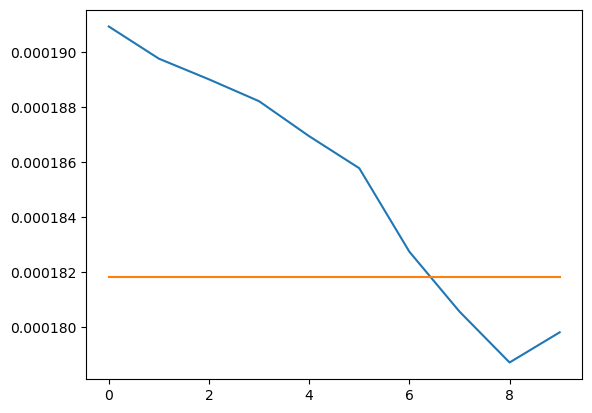

In [141]:
# Loading the newly uploaded 'data_interpolated.txt' and continuing with the conversion of the MATLAB script to Python
data = np.loadtxt('data_interpolated.txt')
n = len(data)

# Extracting x and v from the loaded data
x = data[:, 0]
v = data[:, 1]
depth = x

# x = x[0:10]
# v = v[0:10]

# x = x[10:20]
# v = v[10:20]

# x = x[20:30]
# v = v[20:30]

# x = x[30:40]
# v = v[30:40]

# x = x[40:50]
# v = v[40:50]

x = x[50:]
v = v[50:]


n = len(x)
# Calculating h and delta
h = np.diff(x)
# delta = h * 1.5
delta = h * 5.6

# Calculating two-way travel time (t)
t = np.zeros(n-1)
for i in range(n-1):
    sumtemp = 0
    for j in range(i+1):
        theta = np.arctan(delta[j] / h[j])
        dij = h[j] / np.cos(theta)
        temp = dij / v[j]
        sumtemp += temp
    t[i] = sumtemp * 2

# Preparing matrix M for inversion
m = n - 1
M = np.zeros((m, m))
theta = np.arctan(delta / h)

for j in range(m):
    M[j:, j] = 2 * h[j] / np.cos(theta[j])

# Using least squares to solve for s
s, residuals, rank, s_val = np.linalg.lstsq(M, t, rcond=None)
v_inversion = np.power(s, -1)
s1 = s


I = np.ones(M.shape[0]) # Assuming I is a vector of ones of appropriate length
Nmax = 10 # Maximum number of iterations
epsilon = 1e-10 # epsilon

# s0 = np.ones(s.shape)*1/1615 # Inital guess of s 0-10
# s0 = np.ones(s.shape)*1/2100 # Inital guess of s 10-20
# s0 = np.ones(s.shape)*1/2100 # Inital guess of s 20-30
# s0 = np.ones(s.shape)*1/2450 # Inital guess of s 30-40
# s0 = np.ones(s.shape)*1/4000 # Inital guess of s 40-50
s0 = np.ones(s.shape)*1/5500 # Inital guess of s 50-61

I = np.ones(M.shape[1])  # Assuming M is a 2D numpy array
R = 3

plt.plot(s)
plt.plot(s0)

print(min(s-s0))
print(max(s-s0))

In [105]:
len(x)

11

In [59]:
v

array([1550.842137, 1552.894758, 1554.947379, 1557.      ])

Evaluating combinations: 100%|██████████| 10/10 [00:49<00:00,  4.92s/it]


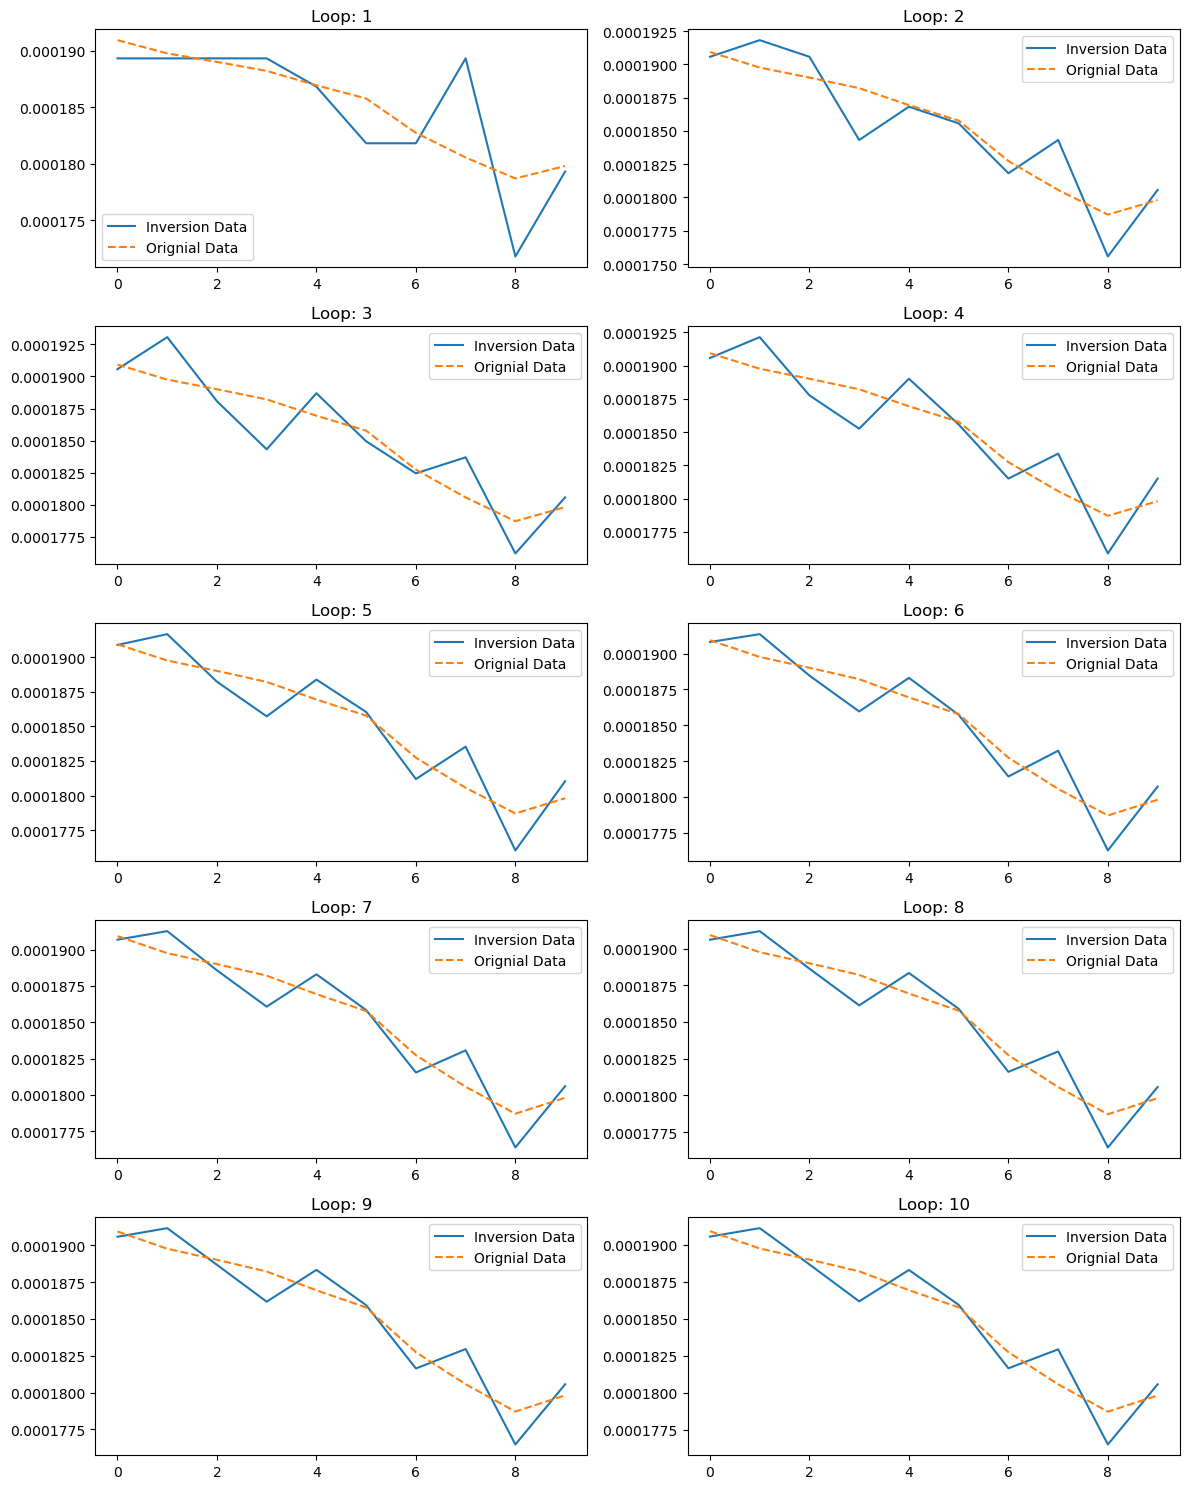

In [107]:
# L = 1e-4 # 0-10
# L = 5e-5 # 10-20
# L = 2.5e-5 # 20-30
# L = 1e-4 # 30-40
# L = 6e-5 # 40-50
L = 1e-5 # 50-:
A = construct_Ad(M, R, 1)


fig, axs = plt.subplots(5, 2, figsize=(12, 15))

for i in tqdm(range(0, 10), desc="Evaluating combinations", colour='green'):
    b = (t + L*M@I - M@s0)/L

    Q = binary_least_squares_qubo(A, b)
    # Solve the QUBO using D-Wave's system
    sampler = EmbeddingComposite(DWaveSampler())
    sampleset = sampler.sample_qubo(Q, num_reads=100)
    # Print the best sample
    q = dict_to_vector_auto(sampleset.first.sample)
    x = binary2real(q, R, 2)
    
    # Update s
    s = s0 + L * (x - I)

    # Check if the solution is within the tolerance epsilon
    # if np.linalg.norm(s - s0) <= epsilon:
    #     break
    # else:
    #     s0 = s
    #     L = L / 2

    s0 = s
    L = L / 2

    axs[i // 2, i % 2].plot(s, label='Inversion Data')
    axs[i // 2, i % 2].plot(s1, label='Orignial Data', linestyle='dashed')
    axs[i // 2, i % 2].set_title(f'Loop: {i + 1}')
    axs[i // 2, i % 2].legend()

    filename = f'results/s_50_61_{i}.txt'
    np.savetxt(filename, s)
fig.tight_layout()


In [142]:
import numpy as np
import os

# Base directory where the files are located
base_dir = 'results_backup'

# Initialize a list to hold the final concatenated arrays
final_s_arrays = []

# Process files with file_end_number from 0 to 9
for file_end_number in range(10):
    # List of arrays to concatenate for this file_end_number
    s_arrays = []
    
    # Loop over the ranges and process them
    for start in range(0, 60, 10):
        end = start + 10
        # Adjust the range for the last group if it doesn't end in a multiple of 10
        if end == 60:
            end = 61  # Assuming 54 is the end of the last range

        # Construct the file name
        file_name = f'{base_dir}/s_{start:02d}_{end}_{file_end_number}.txt'
        # Check if the file exists to avoid errors
        if os.path.isfile(file_name):
            # Load the file
            s_current = np.loadtxt(file_name)
            # Append the last element of the array to itself
            s_current = np.append(s_current, s_current[-1])
            # Add the processed array to the list
            s_arrays.append(s_current)
    
    # Concatenate all the processed arrays for this file_end_number
    if s_arrays:  # Check if there are any arrays to concatenate
        s = np.concatenate(s_arrays)
        final_s_arrays.append(s)  # Add the concatenated array to the final list

final_s_arrays[1].shape

(61,)

In [138]:
import numpy as np

# s0 = np.ones(s.shape)*1/1615 # Inital guess of s 0-10
# s0 = np.ones(s.shape)*1/2100 # Inital guess of s 10-20
# s0 = np.ones(s.shape)*1/2100 # Inital guess of s 20-30
# s0 = np.ones(s.shape)*1/2450 # Inital guess of s 30-40
# s0 = np.ones(s.shape)*1/4000 # Inital guess of s 40-50
# s0 = np.ones(s.shape)*1/5500 # Inital guess of s 50-61


# List of values to fill the array
values = [1615, 2100, 2100, 2450, 4000, 5500]

# Create arrays filled with each value repeated for the specified lengths
first_part = np.full(10, values[0])
second_part = np.full(10, values[1])
third_part = np.full(10, values[2])
fourth_part = np.full(10, values[3])
fifth_part = np.full(10, values[4])  # This part has 14 elements, from index 40 to 53 (inclusive)
sixth_part = np.full(11, values[5])  # This part has 14 elements, from index 40 to 53 (inclusive)

# Concatenate all parts to form the final array
initial_s = np.concatenate((first_part, second_part, third_part, fourth_part, fifth_part, sixth_part))




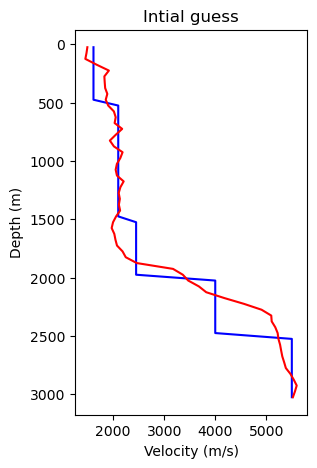

In [139]:
plt.figure(figsize=(3,5))
plt.title('Intial guess')
plt.plot(initial_s, depth, color='blue')
plt.plot(v, x, color='red')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()  # Reverse the Y-axis to have depth increase downwards

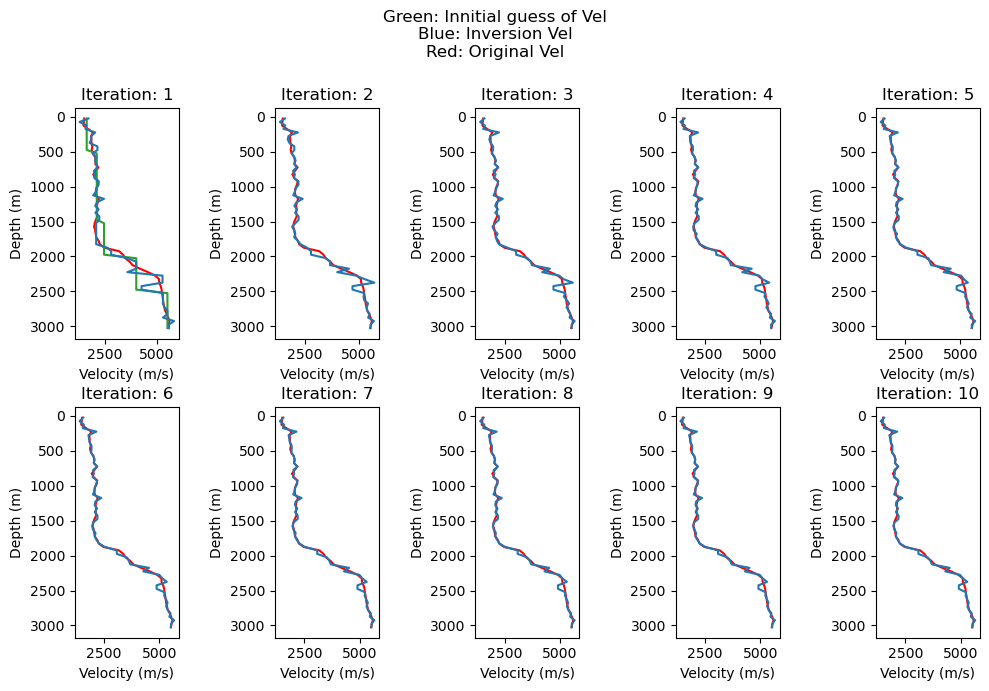

In [140]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming final_s_arrays is already filled with the data arrays to be plotted
# For demonstration, let's create some dummy data

# Set the number of rows and columns for the subplot grid
num_columns = 5
num_rows = 2

# Create a figure and a set of subplots
fig, axs = plt.subplots(num_rows, num_columns, figsize=(10, 7))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Plot each array on a separate subplot
for i, ax in enumerate(axs.flatten()):
    if i < len(final_s_arrays):
        ax.plot(v, x, color = 'red')
        if i == 0:
            ax.plot(initial_s, depth, color='tab:green')
        ax.plot(final_s_arrays[i]**-1, x)
        ax.set_title(f'Iteration: {i+1}')
        ax.set_xlabel('Velocity (m/s)')
        ax.set_ylabel('Depth (m)')
        ax.invert_yaxis()  # Invert the y-axis
    else:
        # If there are no more arrays, turn off the axis to hide the subplot
        ax.axis('off')


# Hide any remaining empty subplots
for i in range(len(final_s_arrays), num_rows * num_columns):
    fig.delaxes(axs[i])

plt.tight_layout()  # Adjust subplots to fit in the figure area
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(top=0.84)  # Adjust top as needed

plt.suptitle("Green: Innitial guess of Vel\nBlue: Inversion Vel\nRed: Original Vel")
plt.show()
